In [7]:
%reload_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from src import const
from src.env.env_basic import WaterLeakEnv


Path.cwd()

PosixPath('/Users/adamzh0u/315_RL/cege_test')

## From data to feature 

In [58]:
df = pd.read_csv(const.PATH_DATA/'simulation'/'Data_water_demand_with_leaks_41_1000.txt')

In [59]:
env = WaterLeakEnv(data = df)
# env._next_observation()
# obs, reward, terminated, info = env.step(1)
# reward

## eps_greedy


record dumped to data/train/eps_greedy_record.npy


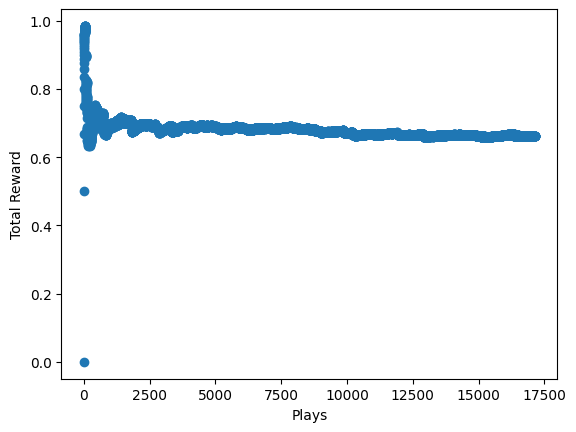

In [47]:
from src.agents.agent_epsgreedy import AgentGreedy

env = WaterLeakEnv(data = df)
agent = AgentGreedy(env)

ls_rewards = agent.run(train=True, eps=0.1)

fig, ax=plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Total Reward")
total_reward = np.cumsum(ls_rewards)
mean_reward = total_reward/np.arange(1,len(total_reward)+1)
ax.scatter(range(len(mean_reward)), mean_reward)

# dqn